In [44]:
import numpy as np
import scipy.optimize as opt

from openptv_python.calibration import Calibration
# from openptv_python.imgcoord import image_coordinates
from openptv_python.orientation import (
    external_calibration,
    full_calibration
)
from openptv_python.parameters import OrientPar, read_control_par
# from openptv_python.trafo import arr_metric_to_pixel
from openptv_python.imgcoord import img_coord
from openptv_python.trafo import pixel_to_metric
from openptv_python.segmentation import fast_targ_rec
from openptv_python.tracking_frame_buf import Target

from openptv_python.sortgrid import (
    nearest_neighbour_pix,
    read_calblock,
    read_sortgrid_par,
    sortgrid,
)


from pathlib import Path


import matplotlib.pyplot as plt
%matplotlib widget


from skimage.io import imread

from typing import List


In [45]:
# working directory
work_dir = Path('/home/user/Downloads/For_Alex_test_34')
par_dir = work_dir / "parameters"
cal_dir = work_dir / "cal"
res_dir = work_dir / "res"

In [46]:
control_file_name = par_dir / "ptv.par"
target_parameters_file_name = par_dir / "targ_rec.par"
# self.control = ControlPar(4)
control = read_control_par(control_file_name)
print(control)


ControlPar(num_cams=4, img_base_name=['cal/cam1bw.tif', 'cal/cam2bw.tif', 'cal/cam3bw.tif', 'cal/cam4bw.tif'], cal_img_base_name=['cal/cam1.tif', 'cal/cam2.tif', 'cal/cam3.tif', 'cal/cam4.tif'], hp_flag=0, all_cam_flag=0, tiff_flag=1, imx=1920, imy=1080, pix_x=0.01, pix_y=0.01, chfield=0, mm=MultimediaPar(nlay=1, n1=1.0, n2=[1.5], d=[1.5], n3=1.33))


In [47]:
orient_par_file_name = par_dir / "orient.par"
orient_par = OrientPar().from_file(orient_par_file_name)

cal = Calibration().from_file(
    cal_dir / "cam1.tif.ori",
    cal_dir / "cam1.tif.addpar",
)
orig_cal = Calibration().from_file(
    cal_dir / "cam1.tif.ori",
    cal_dir / "cam1.tif.addpar",
)

In [48]:
print(cal.added_par)

[0. 0. 0. 0. 0. 1. 0.]


In [49]:
img = imread(cal_dir / "cam1bw.tif")

interactive(children=(IntSlider(value=127, description='thres', max=254, min=1), IntSlider(value=250, descript…

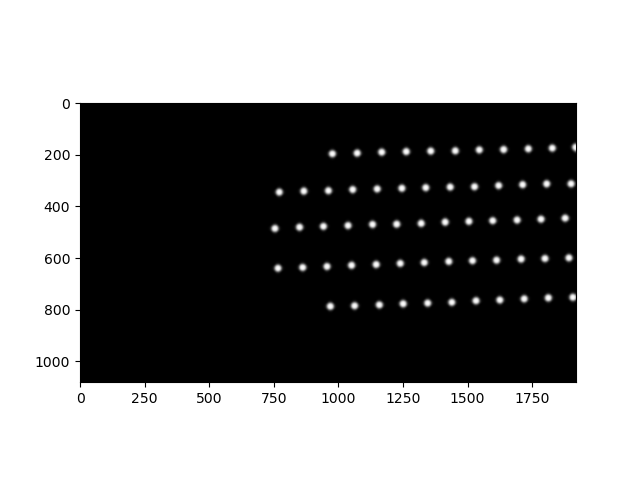

In [50]:

fig, ax = plt.subplots()
plt.ion()


def f(thres, disco, nnmin, nnmax,nxmin,nxmax,nymin,nymax,sumg_min):
    xmin = 0+nxmin//2
    xmax = img.shape[1]-nxmin//2
    ymin = 0+nymin//2
    ymax = img.shape[0]-nxmin//2
    
    targets = fast_targ_rec(img,
                    thres,
                    disco,
                    nnmin,
                    nnmax,
                    nxmin,
                    nxmax,
                    nymin,
                    nymax,
                    sumg_min,
                    xmin,
                    xmax,
                    ymin,
                    ymax)

    print(len(targets))
    print(targets)
    # target_array.sort(key=lambda t: t.y)
    # detections.append(target_array)
    
    # x = [[_.x for _ in cam] for cam in target_array]
    # y = [[_.y for _ in cam] for cam in target_array]
    if len(targets) > 0:
        
        target_array = np.array(targets)
        ax.cla()
        ax.imshow(img, cmap='gray')
        ax.scatter(target_array[:,0],target_array[:,1], c='r', s=3)
        
    else:
        ax.cla()
        ax.imshow(img, cmap='gray')
        
        
    # fig.show()
        
from ipywidgets import interact    
outcome = interact(f, thres=(1,254,1), disco=(1,500,1), nnmin=(0,100,1), nnmax=(0,100,1), nxmin=(0,100,1), nxmax=(1,100,1), nymin=(1,100,1), nymax=(1,100,1), sumg_min=(10,1000,10))

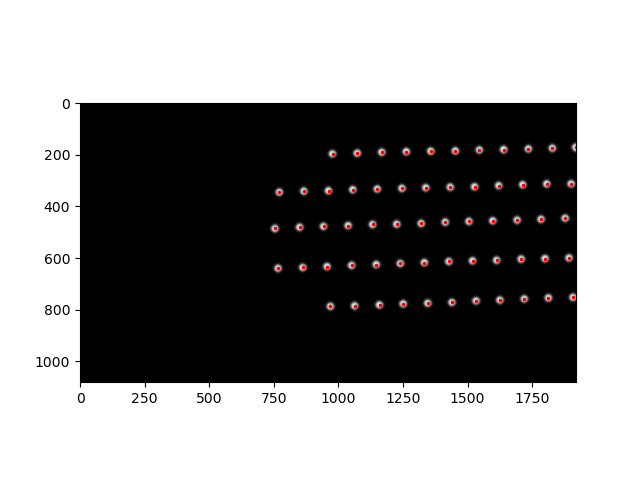

In [51]:
thres = 247
disco = 100
nnmin = 1
nnmax = 100
nxmin = 1
nxmax = 100
nymin = 1
nymax = 100
sumg_min = 100
xmin = 0+nxmin//2
xmax = img.shape[1]-nxmin//2
ymin = 0+nymin//2
ymax = img.shape[0]-nxmin//2

targets = fast_targ_rec(img,
                    thres,
                    disco,
                    nnmin,
                    nnmax,
                    nxmin,
                    nxmax,
                    nymin,
                    nymax,
                    sumg_min,
                    xmin,
                    xmax,
                    ymin,
                    ymax)


fig, ax = plt.subplots()
target_array = np.array(targets)
ax.imshow(img, cmap='gray')
ax.scatter(target_array[:,0],target_array[:,1], c='r', s=3)

In [52]:
par_files = list(par_dir.glob('*.par'))
names = [f.name for f in par_files]
    
from openptv_python.parameters import CalibrationPar
cal_par = CalibrationPar().from_file(par_files[names.index('cal_ori.par')], num_cams = 4)
print(cal_par)

CalibrationPar(fixp_name='cal/target_on_a_side.txt', img_name=['cal/cam1.tif', 'cal/cam2.tif', 'cal/cam3.tif', 'cal/cam4.tif'], img_ori0=['cal/cam1.tif.ori', 'cal/cam2.tif.ori', 'cal/cam3.tif.ori', 'cal/cam4.tif.ori'], tiff_flag=1, pair_flag=1, chfield=0)


In [53]:
targs = [Target() for _ in targets]

for ptx, pt in enumerate(targets):
    targs[ptx].x = pt[0]
    targs[ptx].y = pt[1]

In [54]:
cal_points = read_calblock(work_dir / cal_par.fixp_name)


fix = np.c_[cal_points.x, cal_points.y, cal_points.z]
sorted_pix = sortgrid(cal, control, len(fix), fix, 25, targs)
# sorted_pix

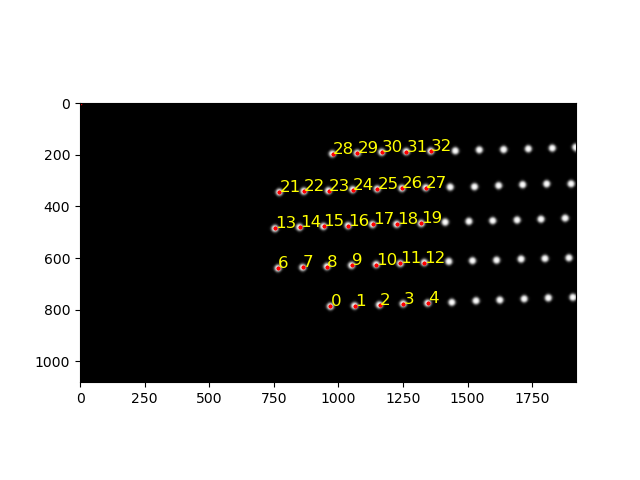

In [55]:
x = [_.x for _ in sorted_pix]
y = [_.y for _ in sorted_pix]
id = [str(_.pnr) for _ in sorted_pix]

fig, ax = plt.subplots()
ax.imshow(img, cmap='gray')
ax.scatter(x, y, c='r', s=3)
for ix,iy,it in zip(x,y,id):
    if it != '-999':
        ax.scatter(ix,iy,c='r', s=3)
        ax.text(ix,iy,it, c='yellow', fontsize=12)

In [56]:
# def residual(calibration_array, ref_pts, targs, control, cc):
#     # print(calibration_array)
#     # print(ref_pts)
#     # print(targs)
#     # print(control)
#     # print(calibration_array)
    
#     c = Calibration()
#     c.set_pos(calibration_array[:3])
#     c.set_angles(calibration_array[3:])
#     c.int_par.cc = cc
#     c.update_rotation_matrix()
    
    
#     # print(f"{c.get_pos()=}")
                
#     residual = 0
#     for i in range(len(targs)):
#         xc, yc = pixel_to_metric(targs[i].x, targs[i].y, control)
#         # print(f"{xc=}, {yc=} mm")
        
#         xp, yp = img_coord(ref_pts[i], c, control.mm)
#         # print(f"{xp=}, {yp=} mm")
#         residual += ((xc - xp)**2 + (yc - yp)**2)
        
#         # print(f"{residual=}")
        
#     return residual
# x0 = np.hstack([cal.get_pos(), cal.get_angles()])
# cc = orig_cal.int_par.cc

# sol = opt.minimize(residual, x0, args=(ref_pts, targs, control, cc), method='Nelder-Mead', tol=1e-6)
# print( residual(np.hstack([orig_cal.get_pos(), orig_cal.get_angles()]), ref_pts, targs, control, orig_cal.int_par.cc))

In [57]:
import copy
def added_par_residual(added_par_array, ref_pts: np.ndarray, targs: List[Target], control, cal):
    # print(calibration_array)
    # print(ref_pts)
    # print(targs)
    # print(control)
    # print(calibration_array)
    c = copy.deepcopy(cal)
    c.added_par = added_par_array
    
    # print(f"{c.get_pos()=}")
                
    residual = 0
    for i in range(len(targs)):
        xc, yc = pixel_to_metric(targs[i].x, targs[i].y, control)
        # print(f"{xc=}, {yc=} mm")
        
        xp, yp = img_coord(ref_pts[i], c, control.mm)
        # print(f"{xp=}, {yp=} mm")
        residual += ((xc - xp)**2 + (yc - yp)**2)
        
        # print(f"{residual=}")
        
    return residual

In [61]:
ref_points = np.hstack([cal_points.x , cal_points.y, cal_points.z])

In [65]:
x0 = np.array(cal.added_par.tolist())

sol = opt.minimize(added_par_residual, x0, args=(ref_points, sorted_pix, control, cal), method='Nelder-Mead', tol=1e-7)
print(f"{sol.x=}")
# print(sol.x - np.hstack([orig_cal.get_pos(), orig_cal.get_angles()]))



sol.x=array([-4.26831007e-02,  5.73365388e-03, -1.39471877e-04, -5.12636281e-02,
        1.98655738e-03,  1.65948514e+00, -8.41335831e-02])


In [66]:
# print(sol.x)
cal.set_added_par(sol.x)
print(cal.added_par)
full_calibration(cal, ref_points, sorted_pix, control, orient_par)
print(cal.added_par)

[-4.26831007e-02  5.73365388e-03 -1.39471877e-04 -5.12636281e-02
  1.98655738e-03  1.65948514e+00 -8.41335831e-02]


ValueError: array must not contain infs or NaNs

In [ ]:
print(cal.get_pos())
print(cal.get_angles())
print(cal.get_primary_point())
print(cal.get_decentering())
print(cal.added_par)